In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aviakompaniya/sample_submission.csv
/kaggle/input/aviakompaniya/train_dataset.csv
/kaggle/input/aviakompaniya/test_dataset.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb # tezkor va samarali gradient boosting framework
from sklearn.ensemble import RandomForestClassifier

In [3]:
train = pd.read_csv('../input/aviakompaniya/train_dataset.csv',index_col=['id'])
test = pd.read_csv('../input/aviakompaniya/test_dataset.csv',index_col=['id'])
sample_sub = pd.read_csv('../input/aviakompaniya/sample_submission.csv')

print(train.shape,test.shape)
sample_sub

(10000, 23) (4000, 22)


,id,satisfaction
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
3995,3996,0
3996,3997,0
3997,3998,0
3998,3999,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             10000 non-null  object 
 1   Customer Type                      10000 non-null  object 
 2   Age                                10000 non-null  int64  
 3   Type of Travel                     10000 non-null  object 
 4   Class                              10000 non-null  object 
 5   Flight Distance                    10000 non-null  int64  
 6   Inflight wifi service              10000 non-null  int64  
 7   Departure/Arrival time convenient  10000 non-null  int64  
 8   Ease of Online booking             10000 non-null  int64  
 9   Gate location                      10000 non-null  int64  
 10  Food and drink                     10000 non-null  int64  
 11  Online boarding                    10000 non-null  int

In [5]:
train.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [6]:
test.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')

In [7]:
train.satisfaction.value_counts()

0    5000
1    5000
Name: satisfaction, dtype: int64

In [8]:
train.groupby('satisfaction').mean().T

satisfaction,0,1
Age,37.225400,41.524800
Flight Distance,924.212800,1534.899600
Inflight wifi service,2.402200,3.158200
Departure/Arrival time convenient,3.168400,2.961800
Ease of Online booking,2.563800,3.031800
Gate location,2.971800,2.990200
Food and drink,2.937400,3.491600
Online boarding,2.666000,4.032200
Seat comfort,3.042600,3.940200
Inflight entertainment,2.869000,3.936800


In [9]:
train.nunique()

Gender                                  2
Customer Type                           2
Age                                    74
Type of Travel                          2
Class                                   3
Flight Distance                      2421
Inflight wifi service                   6
Departure/Arrival time convenient       6
Ease of Online booking                  6
Gate location                           5
Food and drink                          6
Online boarding                         6
Seat comfort                            6
Inflight entertainment                  6
On-board service                        5
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Inflight service                        5
Cleanliness                             6
Departure Delay in Minutes            239
Arrival Delay in Minutes              242
satisfaction                            2
dtype: int64

In [10]:
train['test'] = False
test['test']= True
df = pd.concat([train,test],axis=0)
df.shape

(14000, 24)

<AxesSubplot:>

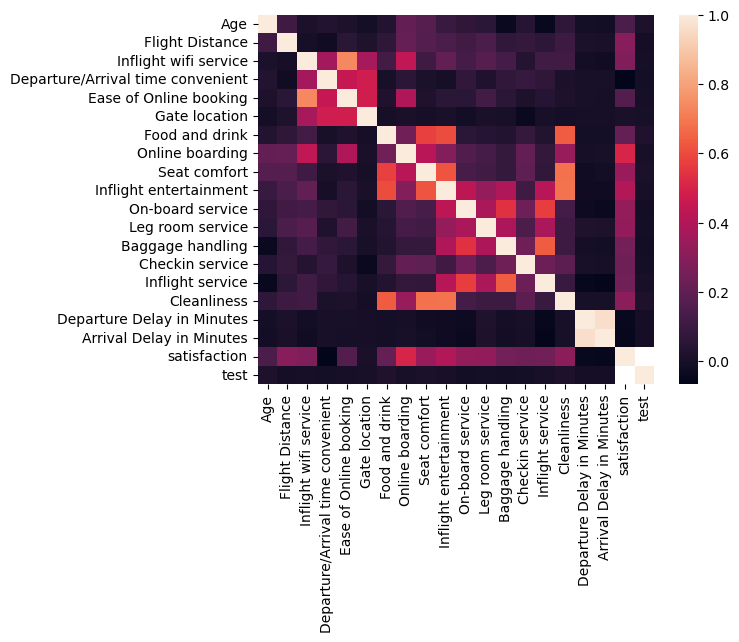

In [11]:
sns.heatmap(df.corr())

In [12]:
for i in df.columns[df.dtypes=='object']:
   df[i]= df[i].factorize()[0]

In [13]:
df.nunique()

Gender                                  2
Customer Type                           2
Age                                    74
Type of Travel                          2
Class                                   3
Flight Distance                      2768
Inflight wifi service                   6
Departure/Arrival time convenient       6
Ease of Online booking                  6
Gate location                           5
Food and drink                          6
Online boarding                         6
Seat comfort                            6
Inflight entertainment                  6
On-board service                        5
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Inflight service                        5
Cleanliness                             6
Departure Delay in Minutes            258
Arrival Delay in Minutes              258
satisfaction                            2
test                              

In [14]:
train = df[df.test==False]
test = df[df.test==True]
print(train.shape,test.shape)

(10000, 24) (4000, 24)


In [15]:
test=test.drop('satisfaction', axis=1)


In [16]:
x = train.copy()
x = x.drop('satisfaction', axis=1)
y= train.satisfaction

In [17]:
%time
mod = lgb.LGBMClassifier()
mod.fit(x,y)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


LGBMClassifier()

In [18]:
from sklearn.model_selection import cross_val_score
print("cross_val_score. :", cross_val_score(mod,x,y, cv=5, scoring='accuracy').mean())

cross_val_score. : 0.9531000000000001


In [19]:
javob = mod.predict_proba(test)

In [20]:
sample_sub = pd.read_csv('/kaggle/input/aviakompaniya/sample_submission.csv')
sample_sub['satisfaction'] = 1-javob


In [21]:
sample_sub

,id,satisfaction
0,1,0.003075
1,2,0.490267
2,3,0.998704
3,4,0.999754
4,5,0.438673
...,...,...
3995,3996,0.823827
3996,3997,0.001183
3997,3998,0.008299
3998,3999,0.991938


In [22]:
sample_sub.to_csv('submission.csv', index=False)